<a href="https://colab.research.google.com/github/Aldrin-Fanir/Hippocampal-Region-Segmentation-UNet/blob/main/HippocampalRegionUNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Required Library

In [1]:
import copy
import os
import random
import zipfile
from math import atan2, cos, sin, sqrt, pi, log

import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from PIL import Image
from numpy import linalg as LA
from torch import optim, nn
from torch.utils.data import DataLoader, random_split
from torch.utils.data.dataset import Dataset
from torchvision import transforms
from tqdm import tqdm

# Drive Mount: Import Google Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Directory of Images and Masks

In [3]:
root_path = '/content/drive/MyDrive/HippocampalRegionSegmentationUNet/Cohort1-Multiplexed Dataset'

In [4]:
print("Is path correct?", os.path.exists(root_path))

Is path correct? True


# Hippocampal Region Dataset

In [5]:
class HippocampalDataset(Dataset):
  def __init__(self, root_path, limit = None):
    self.root_path = root_path
    self.limit = limit

    self.images = sorted([root_path + "/cFos_NeuN_dFos_dataset_images/" + i for i in os.listdir(root_path + "/cFos_NeuN_dFos_dataset_images")])[: self.limit]
    self.masks = sorted([root_path + "/cFos_NeuN_dFos_dataset_masks/" + i for i in os.listdir(root_path + "/cFos_NeuN_dFos_dataset_masks")])[: self.limit]

    self.transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor()
    ])

    if self.limit is None:
      self.limit = len(self.images)


  def __getitem__(self, index):
    img = Image.open(self.images[index]).convert("RGB")
    mask = Image.open(self.masks[index]).convert("L")

    return self.transform(img), self.transform(mask)

  def __len__(self):
    return min(len(self.images), self.limit)


# Test Dataset

Batch 1
Image Shape: torch.Size([1, 3, 256, 256])
Mask Shape: torch.Size([1, 1, 256, 256])


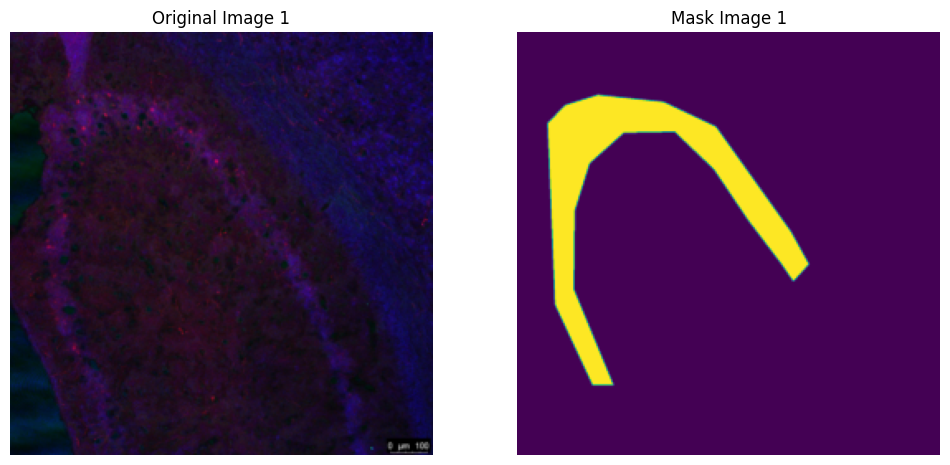

Batch 2
Image Shape: torch.Size([1, 3, 256, 256])
Mask Shape: torch.Size([1, 1, 256, 256])


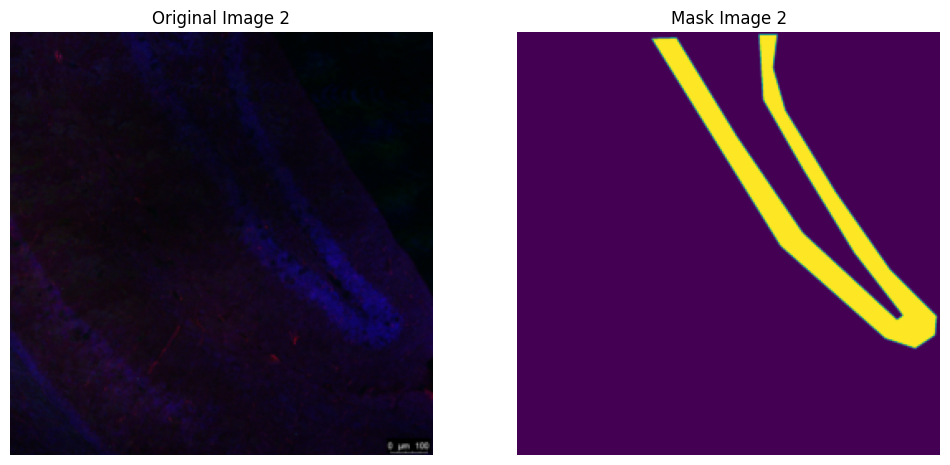

Batch 3
Image Shape: torch.Size([1, 3, 256, 256])
Mask Shape: torch.Size([1, 1, 256, 256])


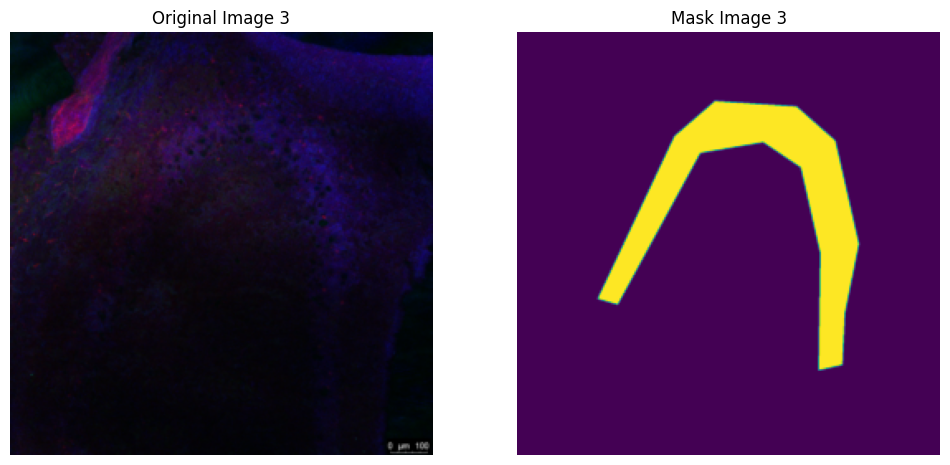

In [6]:
dataset = HippocampalDataset(root_path, limit = 3)

loader = DataLoader(dataset, batch_size = 1, shuffle = True)

for i, (images, masks) in enumerate(loader):
  print(f'Batch {i+1}')
  print(f'Image Shape: {images.shape}')
  print(f'Mask Shape: {masks.shape}')
  plt.figure(figsize=(12, 6))

  #Train Image
  plt.subplot(1, 2, 1)
  plt.imshow(images[0].permute(1, 2, 0).cpu().numpy())
  plt.title(f'Original Image {i+1}')
  plt.axis('off')

  #Train Mask
  plt.subplot(1, 2, 2)
  plt.imshow(masks[0].permute(1, 2, 0).cpu().numpy())
  plt.title(f'Mask Image {i+1}')
  plt.axis('off')

  plt.show()

# Create Model

# Double Convolution

In [7]:
class DoubleConv(nn.Module):
  def __init__(self, in_channels, out_channels):
    super().__init__()
    self.conv_op = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size = 3, padding = 1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace = True),
        nn.Conv2d(out_channels, out_channels, kernel_size = 3, padding = 1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace = True)
    )

  def forward(self, x):
    return self.conv_op(x)

# Downsampling

In [8]:
class DownSample(nn.Module):
  def __init__(self, in_channels, out_channels):
    super().__init__()
    self.conv = DoubleConv(in_channels, out_channels)
    self.pool = nn.MaxPool2d(kernel_size = 2, stride = 2)

  def forward(self, x):
    down = self.conv(x)
    p = self.pool(down)

    return down, p

# Upsampling

In [9]:
class UpSample(nn.Module):
  def __init__(self, in_channels, out_channels):
    super().__init__()
    self.up = nn.ConvTranspose2d(in_channels, in_channels//2, kernel_size = 2, stride = 2)
    self.conv = DoubleConv(in_channels, out_channels)

  def forward(self, x1, x2):
    x1 = self.up(x1)
    x = torch.cat([x1, x2], 1)

    return self.conv(x)

# UNet Architecture

In [10]:
class UNet(nn.Module):
  def __init__(self, in_channels, num_classes):
    super().__init__()

    self.down_convolution_1 = DownSample(in_channels, 64)
    self.down_convolution_2 = DownSample(64, 128)
    self.down_convolution_3 = DownSample(128, 256)
    #self.down_convolution_4 = DownSample(256, 512)

    self.bottle_neck = DoubleConv(256, 512)

    self.up_convolution_1 = UpSample(512, 256)
    self.up_convolution_2 = UpSample(256, 128)
    self.up_convolution_3 = UpSample(128, 64)
    #self.up_convolution_4 = UpSample(128, 64)

    self.output = nn.Conv2d(64, out_channels = num_classes, kernel_size = 1)



  def forward(self, x):
    down_1, p1 = self.down_convolution_1(x)
    down_2, p2 = self.down_convolution_2(p1)
    down_3, p3 = self.down_convolution_3(p2)
    #down_4, p4 = self.down_convolution_4(p3)

    b = self.bottle_neck(p3)

    up_1 = self.up_convolution_1(b, down_3)
    up_2 = self.up_convolution_2(up_1, down_2)
    up_3 = self.up_convolution_3(up_2, down_1)
    #up_4 = self.up_convolution_4(up_3, down_1)

    return self.output(up_3)

# Trainning The Model

# Early Sopping

In [11]:
class EarlyStopping:
  def __init__(self, patience = 5, delta = 0):
    super().__init__()
    self.patience = patience
    self.delta = delta
    self.best_score = None
    self. early_stop = False
    self.counter = 0
    self.best_model_state = None


  def __call__(self, val_loss, model):
    score = -val_loss

    if self.best_score is None:
      self.best_score = score
      self.best_model_state = model.state_dict()
    elif score<self.best_score + self.delta:
      self.counter += 1
      if self.counter>= self.patience:
        self.early_stop = True
    else:
      self.best_score = score
      self.best_model_state = model.state_dict()
      self.counter = 0


  def load_best_model(self, model):
    model.load_state_dict(self.best_model_state)

In [12]:
train_dataset = HippocampalDataset(root_path)
generator = torch.Generator().manual_seed(42)

In [13]:
train_dataset, test_dataset = random_split(train_dataset, [0.8, 0.2], generator = generator)

In [14]:
test_dataset, val_dataset = random_split(test_dataset, [0.5, 0.5], generator = generator)

**Running this experiment with CUDA**

In [15]:
num_workers = 0
device = "cuda" if torch.cuda.is_available() else "cpu"

if device == "cuda":
  num_workers = torch.cuda.device_count()*4

**Now We setup out model using the AdamW optimizer and the BCEWithLogitsLoss**

In [16]:
Learning_Rate = 1e-4
batch_size = 2

train_dataloader = DataLoader(dataset = train_dataset, num_workers = num_workers, pin_memory = True, batch_size = batch_size, shuffle = True)
test_dataloader = DataLoader(dataset = test_dataset, num_workers = num_workers, pin_memory = True, batch_size = batch_size, shuffle = False)
val_dataloader = DataLoader(dataset = val_dataset, num_workers = num_workers, pin_memory = True, batch_size = batch_size, shuffle = False)

model = UNet(in_channels = 3, num_classes = 1).to(device)
optimizer = optim.AdamW(model.parameters(), lr = Learning_Rate)
criterion = nn.BCEWithLogitsLoss()

early_stopping = EarlyStopping(patience = 15, delta = 0.001)

In [17]:
print(len(train_dataset))
print(len(test_dataset))
print(len(val_dataset))

239
30
29


**Evaluating Segmentation Performance with DICEMetric**

In [18]:
def dice_coefficient(prediction, target, epsilon = 1e-7):
  prediction_copy = prediction.clone()

  prediction_copy[prediction_copy<0] = 0
  prediction_copy[prediction_copy>0] = 1

  intersection = abs(torch.sum(prediction_copy * target))
  union = torch.sum(prediction_copy) + torch.sum(target)
  dice = (2.0 * intersection + epsilon) / (union + epsilon)

  return dice

In [19]:
torch.cuda.empty_cache()

# Training

In [20]:
epochs = 301
train_losses = []
train_dcs = []

val_losses = []
val_dcs = []

for epoch in tqdm(range(epochs)):
  model.train()
  train_running_loss = 0
  traing_running_dc = 0

  for idx, img_mask in enumerate(tqdm(train_dataloader, position = 0, leave=True)):
    img = img_mask[0].float().to(device)
    mask = img_mask[1].float().to(device)

    y_pred = model(img)
    optimizer.zero_grad()

    dc = dice_coefficient(y_pred, mask)
    loss = criterion(y_pred, mask)

    train_running_loss += loss.item()
    traing_running_dc += dc.item()

    loss.backward()
    optimizer.step()

  train_loss = train_running_loss/(idx + 1)
  train_dc = traing_running_dc/(idx + 1)

  train_losses.append(train_loss)
  train_dcs.append(train_dc)




  model.eval()
  val_running_loss = 0
  val_running_dc = 0

  with torch.no_grad():
    for idx, img_mask in enumerate(tqdm(val_dataloader, position=0, leave = True)):
      img = img_mask[0].float().to(device)
      mask = img_mask[1].float().to(device)

      y_pred = model(img)
      loss = criterion(y_pred , mask)
      dc = dice_coefficient(y_pred, mask)

      val_running_loss += loss.item()
      val_running_dc += dc.item()

    val_loss = val_running_loss / (idx + 1)
    val_dc = val_running_dc / (idx + 1)

  val_losses.append(val_loss)
  val_dcs.append(val_dc)



  print("-" * 30)
  print(f"Training Loss EPOCH {epoch + 1}: {train_loss:.4f}")
  print(f"Training DICE EPOCH {epoch + 1}: {train_dc:.4f}")
  print("\n")
  print(f"Validation Loss EPOCH {epoch + 1}: {val_loss:.4f}")
  print(f"Validation DICE EPOCH {epoch + 1}: {val_dc:.4f}")
  print("-" * 30)


  early_stopping(val_loss, model)
  if early_stopping.early_stop:
    print("Early Stopping")
    break

early_stopping.load_best_model(model)

  0%|          | 1/301 [00:22<1:50:24, 22.08s/it]

------------------------------
Training Loss EPOCH 1: 0.4239
Training DICE EPOCH 1: 0.5519


Validation Loss EPOCH 1: 0.3475
Validation DICE EPOCH 1: 0.5708
------------------------------


  1%|          | 2/301 [00:26<57:43, 11.58s/it]  

------------------------------
Training Loss EPOCH 2: 0.3204
Training DICE EPOCH 2: 0.5858


Validation Loss EPOCH 2: 0.2815
Validation DICE EPOCH 2: 0.5868
------------------------------


  1%|          | 3/301 [00:30<40:47,  8.21s/it]

------------------------------
Training Loss EPOCH 3: 0.2771
Training DICE EPOCH 3: 0.6027


Validation Loss EPOCH 3: 0.3020
Validation DICE EPOCH 3: 0.5791
------------------------------


  1%|▏         | 4/301 [00:34<32:55,  6.65s/it]

------------------------------
Training Loss EPOCH 4: 0.2499
Training DICE EPOCH 4: 0.6164


Validation Loss EPOCH 4: 0.2440
Validation DICE EPOCH 4: 0.6117
------------------------------


  2%|▏         | 5/301 [00:38<28:29,  5.77s/it]

------------------------------
Training Loss EPOCH 5: 0.2221
Training DICE EPOCH 5: 0.6421


Validation Loss EPOCH 5: 0.2068
Validation DICE EPOCH 5: 0.6457
------------------------------


  2%|▏         | 6/301 [00:43<25:40,  5.22s/it]

------------------------------
Training Loss EPOCH 6: 0.2051
Training DICE EPOCH 6: 0.6502


Validation Loss EPOCH 6: 0.1967
Validation DICE EPOCH 6: 0.6544
------------------------------


  2%|▏         | 7/301 [00:47<24:00,  4.90s/it]

------------------------------
Training Loss EPOCH 7: 0.1867
Training DICE EPOCH 7: 0.6829


Validation Loss EPOCH 7: 0.1959
Validation DICE EPOCH 7: 0.5947
------------------------------


  3%|▎         | 8/301 [00:51<22:42,  4.65s/it]

------------------------------
Training Loss EPOCH 8: 0.1740
Training DICE EPOCH 8: 0.6938


Validation Loss EPOCH 8: 0.2840
Validation DICE EPOCH 8: 0.5742
------------------------------


  3%|▎         | 9/301 [00:55<21:56,  4.51s/it]

------------------------------
Training Loss EPOCH 9: 0.1647
Training DICE EPOCH 9: 0.7013


Validation Loss EPOCH 9: 0.1690
Validation DICE EPOCH 9: 0.6297
------------------------------


  3%|▎         | 10/301 [01:00<21:35,  4.45s/it]

------------------------------
Training Loss EPOCH 10: 0.1559
Training DICE EPOCH 10: 0.7057


Validation Loss EPOCH 10: 0.1562
Validation DICE EPOCH 10: 0.7008
------------------------------


  4%|▎         | 11/301 [01:04<21:04,  4.36s/it]

------------------------------
Training Loss EPOCH 11: 0.1437
Training DICE EPOCH 11: 0.7260


Validation Loss EPOCH 11: 0.1522
Validation DICE EPOCH 11: 0.6930
------------------------------


  4%|▍         | 12/301 [01:08<20:38,  4.29s/it]

------------------------------
Training Loss EPOCH 12: 0.1400
Training DICE EPOCH 12: 0.7347


Validation Loss EPOCH 12: 0.1401
Validation DICE EPOCH 12: 0.7154
------------------------------


  4%|▍         | 13/301 [01:12<20:41,  4.31s/it]

------------------------------
Training Loss EPOCH 13: 0.1347
Training DICE EPOCH 13: 0.7355


Validation Loss EPOCH 13: 0.1571
Validation DICE EPOCH 13: 0.7073
------------------------------


  5%|▍         | 14/301 [01:16<20:25,  4.27s/it]

------------------------------
Training Loss EPOCH 14: 0.1314
Training DICE EPOCH 14: 0.7365


Validation Loss EPOCH 14: 0.1547
Validation DICE EPOCH 14: 0.6073
------------------------------


  5%|▍         | 15/301 [01:20<20:12,  4.24s/it]

------------------------------
Training Loss EPOCH 15: 0.1280
Training DICE EPOCH 15: 0.7385


Validation Loss EPOCH 15: 0.1487
Validation DICE EPOCH 15: 0.6656
------------------------------


  5%|▌         | 16/301 [01:25<20:20,  4.28s/it]

------------------------------
Training Loss EPOCH 16: 0.1222
Training DICE EPOCH 16: 0.7547


Validation Loss EPOCH 16: 0.1607
Validation DICE EPOCH 16: 0.6777
------------------------------


  6%|▌         | 17/301 [01:29<20:07,  4.25s/it]

------------------------------
Training Loss EPOCH 17: 0.1252
Training DICE EPOCH 17: 0.7323


Validation Loss EPOCH 17: 0.1429
Validation DICE EPOCH 17: 0.6739
------------------------------


  6%|▌         | 18/301 [01:33<19:53,  4.22s/it]

------------------------------
Training Loss EPOCH 18: 0.1141
Training DICE EPOCH 18: 0.7683


Validation Loss EPOCH 18: 0.1303
Validation DICE EPOCH 18: 0.7501
------------------------------


  6%|▋         | 19/301 [01:37<19:52,  4.23s/it]

------------------------------
Training Loss EPOCH 19: 0.1092
Training DICE EPOCH 19: 0.7776


Validation Loss EPOCH 19: 0.1410
Validation DICE EPOCH 19: 0.5281
------------------------------


  7%|▋         | 20/301 [01:42<19:41,  4.20s/it]

------------------------------
Training Loss EPOCH 20: 0.1098
Training DICE EPOCH 20: 0.7710


Validation Loss EPOCH 20: 0.1299
Validation DICE EPOCH 20: 0.7399
------------------------------


  7%|▋         | 21/301 [01:46<19:35,  4.20s/it]

------------------------------
Training Loss EPOCH 21: 0.1069
Training DICE EPOCH 21: 0.7741


Validation Loss EPOCH 21: 0.1208
Validation DICE EPOCH 21: 0.7328
------------------------------


  7%|▋         | 22/301 [01:50<19:40,  4.23s/it]

------------------------------
Training Loss EPOCH 22: 0.1086
Training DICE EPOCH 22: 0.7685


Validation Loss EPOCH 22: 0.1514
Validation DICE EPOCH 22: 0.7157
------------------------------


  8%|▊         | 23/301 [01:54<19:27,  4.20s/it]

------------------------------
Training Loss EPOCH 23: 0.1033
Training DICE EPOCH 23: 0.7816


Validation Loss EPOCH 23: 0.1404
Validation DICE EPOCH 23: 0.7425
------------------------------


  8%|▊         | 24/301 [01:58<19:16,  4.17s/it]

------------------------------
Training Loss EPOCH 24: 0.0987
Training DICE EPOCH 24: 0.7901


Validation Loss EPOCH 24: 0.1481
Validation DICE EPOCH 24: 0.7233
------------------------------


  8%|▊         | 25/301 [02:03<19:23,  4.22s/it]

------------------------------
Training Loss EPOCH 25: 0.0941
Training DICE EPOCH 25: 0.8063


Validation Loss EPOCH 25: 0.1447
Validation DICE EPOCH 25: 0.7309
------------------------------


  9%|▊         | 26/301 [02:07<19:18,  4.21s/it]

------------------------------
Training Loss EPOCH 26: 0.0948
Training DICE EPOCH 26: 0.7963


Validation Loss EPOCH 26: 0.1379
Validation DICE EPOCH 26: 0.6824
------------------------------


  9%|▉         | 27/301 [02:11<19:06,  4.18s/it]

------------------------------
Training Loss EPOCH 27: 0.0946
Training DICE EPOCH 27: 0.7990


Validation Loss EPOCH 27: 0.1209
Validation DICE EPOCH 27: 0.7573
------------------------------


  9%|▉         | 28/301 [02:15<19:12,  4.22s/it]

------------------------------
Training Loss EPOCH 28: 0.0945
Training DICE EPOCH 28: 0.7965


Validation Loss EPOCH 28: 0.1214
Validation DICE EPOCH 28: 0.7635
------------------------------


 10%|▉         | 29/301 [02:19<19:03,  4.20s/it]

------------------------------
Training Loss EPOCH 29: 0.0902
Training DICE EPOCH 29: 0.8061


Validation Loss EPOCH 29: 0.1222
Validation DICE EPOCH 29: 0.7727
------------------------------


 10%|▉         | 30/301 [02:24<19:03,  4.22s/it]

------------------------------
Training Loss EPOCH 30: 0.0873
Training DICE EPOCH 30: 0.8191


Validation Loss EPOCH 30: 0.1160
Validation DICE EPOCH 30: 0.7639
------------------------------


 10%|█         | 31/301 [02:28<19:05,  4.24s/it]

------------------------------
Training Loss EPOCH 31: 0.0848
Training DICE EPOCH 31: 0.8221


Validation Loss EPOCH 31: 0.1221
Validation DICE EPOCH 31: 0.7482
------------------------------


 11%|█         | 32/301 [02:32<18:58,  4.23s/it]

------------------------------
Training Loss EPOCH 32: 0.0905
Training DICE EPOCH 32: 0.8067


Validation Loss EPOCH 32: 0.1467
Validation DICE EPOCH 32: 0.7375
------------------------------


 11%|█         | 33/301 [02:36<18:50,  4.22s/it]

------------------------------
Training Loss EPOCH 33: 0.0885
Training DICE EPOCH 33: 0.8111


Validation Loss EPOCH 33: 0.1449
Validation DICE EPOCH 33: 0.7535
------------------------------


 11%|█▏        | 34/301 [02:41<18:54,  4.25s/it]

------------------------------
Training Loss EPOCH 34: 0.0821
Training DICE EPOCH 34: 0.8291


Validation Loss EPOCH 34: 0.1372
Validation DICE EPOCH 34: 0.7441
------------------------------


 12%|█▏        | 35/301 [02:45<18:43,  4.22s/it]

------------------------------
Training Loss EPOCH 35: 0.0822
Training DICE EPOCH 35: 0.8256


Validation Loss EPOCH 35: 0.1363
Validation DICE EPOCH 35: 0.6900
------------------------------


 12%|█▏        | 36/301 [02:49<18:42,  4.24s/it]

------------------------------
Training Loss EPOCH 36: 0.0805
Training DICE EPOCH 36: 0.8313


Validation Loss EPOCH 36: 0.1305
Validation DICE EPOCH 36: 0.7362
------------------------------


 12%|█▏        | 37/301 [02:53<18:44,  4.26s/it]

------------------------------
Training Loss EPOCH 37: 0.0807
Training DICE EPOCH 37: 0.8294


Validation Loss EPOCH 37: 0.1225
Validation DICE EPOCH 37: 0.7397
------------------------------


 13%|█▎        | 38/301 [02:58<18:33,  4.23s/it]

------------------------------
Training Loss EPOCH 38: 0.0728
Training DICE EPOCH 38: 0.8453


Validation Loss EPOCH 38: 0.1214
Validation DICE EPOCH 38: 0.7579
------------------------------


 13%|█▎        | 39/301 [03:02<18:26,  4.23s/it]

------------------------------
Training Loss EPOCH 39: 0.0762
Training DICE EPOCH 39: 0.8384


Validation Loss EPOCH 39: 0.1192
Validation DICE EPOCH 39: 0.7837
------------------------------


 13%|█▎        | 40/301 [03:06<18:21,  4.22s/it]

------------------------------
Training Loss EPOCH 40: 0.0728
Training DICE EPOCH 40: 0.8463


Validation Loss EPOCH 40: 0.1308
Validation DICE EPOCH 40: 0.7245
------------------------------


 14%|█▎        | 41/301 [03:10<18:13,  4.20s/it]

------------------------------
Training Loss EPOCH 41: 0.0719
Training DICE EPOCH 41: 0.8481


Validation Loss EPOCH 41: 0.1478
Validation DICE EPOCH 41: 0.6421
------------------------------


 14%|█▍        | 42/301 [03:15<18:16,  4.23s/it]

------------------------------
Training Loss EPOCH 42: 0.0734
Training DICE EPOCH 42: 0.8444


Validation Loss EPOCH 42: 0.1152
Validation DICE EPOCH 42: 0.7703
------------------------------


 14%|█▍        | 43/301 [03:19<18:07,  4.22s/it]

------------------------------
Training Loss EPOCH 43: 0.0679
Training DICE EPOCH 43: 0.8577


Validation Loss EPOCH 43: 0.1185
Validation DICE EPOCH 43: 0.7704
------------------------------


 15%|█▍        | 44/301 [03:23<18:01,  4.21s/it]

------------------------------
Training Loss EPOCH 44: 0.0665
Training DICE EPOCH 44: 0.8558


Validation Loss EPOCH 44: 0.1267
Validation DICE EPOCH 44: 0.7608
------------------------------


 15%|█▍        | 44/301 [03:27<20:13,  4.72s/it]

------------------------------
Training Loss EPOCH 45: 0.0666
Training DICE EPOCH 45: 0.8606


Validation Loss EPOCH 45: 0.1263
Validation DICE EPOCH 45: 0.7630
------------------------------
Early Stopping


# Model Save

In [21]:
torch.save(model.state_dict(), '/content/drive/MyDrive/HippocampalRegionSegmentationUNet/HippocampalRegionCohortMultiplexUNet301.pth')

# Results


**Training and Validation**



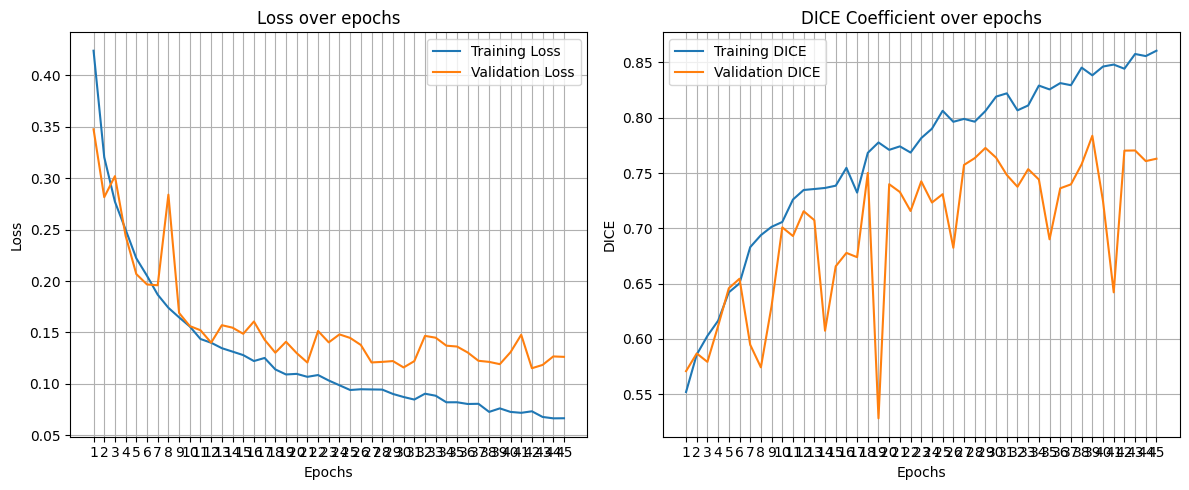

In [22]:
epochs_list = list(range(1, len(train_losses) + 1))

plt.figure(figsize=(12,5))
plt.subplot(1, 2, 1)
plt.plot(epochs_list, train_losses, label='Training Loss')
plt.plot(epochs_list, val_losses, label='Validation Loss')
plt.xticks(ticks=list(range(1, len(train_losses)+1, 1)))
plt.title('Loss over epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid()
plt.tight_layout()
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_list, train_dcs, label='Training DICE')
plt.plot(epochs_list, val_dcs, label='Validation DICE')
plt.xticks(ticks=list(range(1, len(train_losses)+1, 1)))
plt.title('DICE Coefficient over epochs')
plt.xlabel('Epochs')
plt.ylabel('DICE')
plt.grid()
plt.tight_layout()
plt.legend()

plt.show()

# Test

In [23]:
model_path = '/content/drive/MyDrive/HippocampalRegionSegmentationUNet/HippocampalRegionCohortMultiplexUNet301.pth'
trained_model = UNet(in_channels = 3, num_classes = 1).to(device)
trained_model.load_state_dict(torch.load(model_path, map_location = torch.device(device)))

<All keys matched successfully>

In [24]:
test_running_loss = 0
test_running_dc = 0

with torch.no_grad():
  for idx, img_mask in enumerate(tqdm(test_dataloader, position=0, leave = True)):
    img = img_mask[0].float().to(device)
    mask = img_mask[1].float().to(device)

    y_pred = trained_model(img)
    loss = criterion(y_pred , mask)
    dc = dice_coefficient(y_pred, mask)

    test_running_loss += loss.item()
    test_running_dc += dc.item()

  test_loss = test_running_loss / (idx + 1)
  test_dc = test_running_dc / (idx + 1)

100%|██████████| 15/15 [00:02<00:00,  5.17it/s]


In [25]:
print(f'Test Loss: {test_loss:.4f}')
print(f'Test DICE: {test_dc:.4f}')

Test Loss: 0.1160
Test DICE: 0.7745


In [26]:
def random_image_inference(image_tensor, mask_tensor, image_paths, model_path, device):
    model = UNet(in_channels=3, num_classes=1).to(device)
    model.load_state_dict(torch.load(model_path, map_location=torch.device(device)))
    model.eval()

    for img_tensor, mask_tensor_item, img_path in zip(image_tensor, mask_tensor, image_paths):
        img = img_tensor.to(device)
        pred_mask = model(img.unsqueeze(0))
        pred_mask = pred_mask.squeeze(0).permute(1, 2, 0)


        mask = mask_tensor_item.permute(1, 2, 0).to(device)


        dice = dice_coefficient(pred_mask.cpu(), mask.cpu())
        print(f'Image: {os.path.basename(img_path)}, DICE coefficient: {round(float(dice),5)}')

        img_disp = img.cpu().detach().permute(1, 2, 0)
        pred_mask_disp = pred_mask.cpu().detach()
        pred_mask_disp[pred_mask_disp < 0] = 0
        pred_mask_disp[pred_mask_disp > 0] = 1


        plt.figure(figsize=(5,7))
        plt.subplot(131), plt.imshow(img_disp), plt.title("Original Image")
        plt.subplot(132), plt.imshow(pred_mask_disp.squeeze(), cmap='gray'), plt.title("Predicted Mask")
        plt.subplot(133), plt.imshow(mask.cpu().squeeze(), cmap='gray'), plt.title("Mask")
        plt.show()

**Load Some Random Images**

In [27]:
n = 10
image_tensors = []
mask_tensors = []
image_paths = []

original_dataset = HippocampalDataset(root_path)


for i in range(n):
  random_index = random.randint(0, len(test_dataloader.dataset) - 1)

  original_index = test_dataloader.dataset.indices[random_index]
  random_sample = test_dataloader.dataset[random_index]

  image_tensors.append(random_sample[0])
  mask_tensors.append(random_sample[1])

  image_paths.append(original_dataset.images[original_index])

/tmp/ipython-input-82112173.py:16: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at /pytorch/torch/csrc/autograd/generated/python_variable_methods.cpp:835.)
  print(f'Image: {os.path.basename(img_path)}, DICE coefficient: {round(float(dice),5)}')


Image: 10ca3-13_2.tif, DICE coefficient: 0.87817


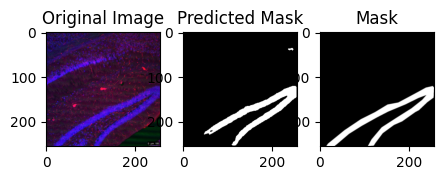

Image: 14dg-15_2.tif, DICE coefficient: 0.93083


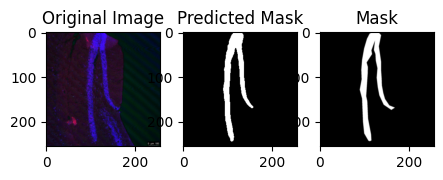

Image: 10.2dg-5_2.tif, DICE coefficient: 0.91544


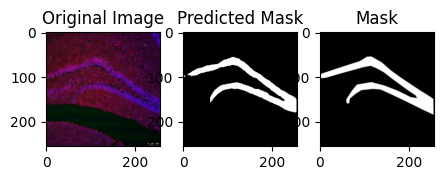

Image: 10dg-12_2.tif, DICE coefficient: 0.72345


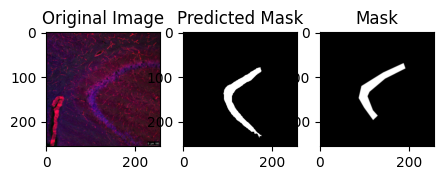

Image: 11ca3-16_2.tif, DICE coefficient: 0.44824


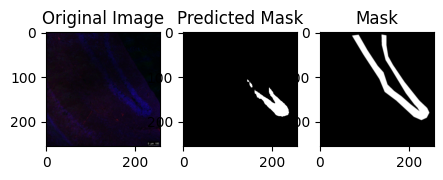

Image: 10ca3-13_2.tif, DICE coefficient: 0.87817


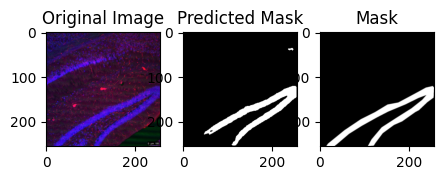

Image: 14dg-12_2.tif, DICE coefficient: 0.58398


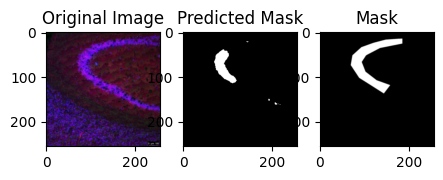

Image: 14dg-8_2.tif, DICE coefficient: 0.74281


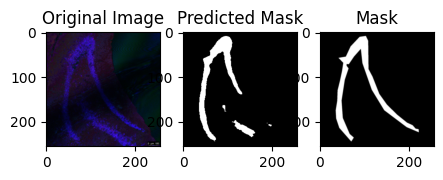

Image: 10dg-16_2.tif, DICE coefficient: 0.7874


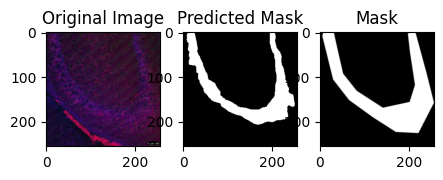

Image: 14ca3-11_2.tif, DICE coefficient: 0.80404


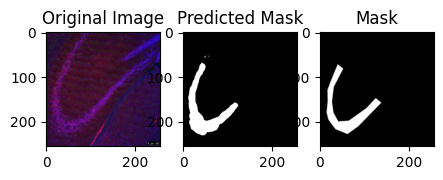

In [28]:
random_image_inference(image_tensors, mask_tensors, image_paths, model_path, device='cpu')